In [3]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import scipy as sp
from sklearn import tree

Here we have written a function to remove stopwords and punctuation marks from text and then perform lemmatization on the text.

In [2]:
#Here I am creating a basic text processing function, to do text cleaning
#lemmatization, stop word removal. 
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def text_process(text):
    lemmatiser = WordNetLemmatizer()
    #Remove Punctuation Marks 
    nopunct=[char for char in text if char not in string.punctuation]
    nopunct=''.join(nopunct)
    #Lemmatisation 
    a=''
    i=0
    for i in range(len(nopunct.split())):
        b=lemmatiser.lemmatize(nopunct.split()[i], pos="v")
        a=a+b+' '
    #Removal of Stopwords
    words = ""
    for word in a.split():
        if word.lower():
#             if word not in stopwords.words("english"):
            words = words + word + " "
    
    return words

Using the csv created in the earlier notebook ,applying the text processing function
written in the above step to all emails.

In [3]:
#Process the text and create new column Processed Text. Dropping all rows in which
#the email length is np.NaN, the Author is np.NaN
# Enter the path to the Enron 29 feature csv file created from Extracting Features step. Remember
# in that step author sampling was already done.
df = pd.read_csv("./Enron_29_Features.csv").drop(["Unnamed: 0"], axis=1)
df = df[df["Email Length"].notna()]
df = df[df["Author"].notna()]
clean_text = df["Text"].apply(lambda row: text_process(row))
df["Processed Text"] = clean_text

Label encoding the Folder attribute since this is the output label we would like to predict and 
dropping all attributes that are not useful

In [4]:
#Label encoding the Folder attribute. Since this is the output label we
#would like to predict.
y = df["Folder"]
le = LabelEncoder()
y = le.fit_transform(y)

#Dropping all unrequired attributes. 
X = df.drop(["Author", "File", "Raw Text", "Message ID", "Folder", "Text"], axis=1)
X

,Email Length,Digit Density,Space Density,Number of Paragraphs,Average Sentences per Paragraph,Farewell Words,Freq Punc,Last Punc,Average Word Length,Average Sentence Length,...,Polarity,Most Common POS,Single Sentence,Greeting,Most Common Word,Freq Most Common Word,Total Special Character Count,Max Occurring Special Char,Count of Max Special Char,Processed Text
0,22,0.000000,0.227273,1.0,1.0,Other,.,.,4.400000,13.500000,...,0.000000,RB,True,Here,Here,1,0,None,0,Here be the AES document
1,9,0.000000,0.444444,1.0,1.0,Other,!,!,3.000000,6.500000,...,0.000000,RB,True,Back,Back,1,0,None,0,Back at cha
2,277,0.000000,0.288809,5.0,1.6,kay,.,.,3.927536,45.750000,...,0.133333,NNP,False,Ok,I,4,1,&,1,Ok Ill follow up The insanity continue I final...
3,159,0.000000,0.308176,3.0,2.0,kay,.,",",3.761905,42.200000,...,-0.250000,NN,False,Opps,the,3,0,None,0,Opps Sorry about the confusion We be sell the ...
4,39,0.000000,0.384615,2.0,1.0,kay,",",.,3.545455,27.500000,...,0.000000,NNP,True,Sheila,Sheila,1,0,None,0,Sheila I should have send this to you as well ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,56,0.000000,0.285714,1.0,1.0,ss,.,.,4.000000,36.000000,...,0.000000,NNP,True,Cathy,Cathy,1,0,None,0,Cathy and I leave a message for Per since he o...
19996,163,0.030675,0.257669,1.0,2.0,Other,"""",.,4.657143,70.000000,...,0.000000,NNP,False,Robert,executed,2,0,None,0,Robert The execute Representative Agreement be...
19997,327,0.009174,0.256881,5.0,1.4,thanks,.,.,4.528571,60.285714,...,0.233333,NN,False,Mara,to,4,6,(,3,Mara 1 The second setoff paragraph be intend t...
19998,758,0.035620,0.234828,6.0,2.0,853,.,:,4.524390,63.866667,...,0.040909,NNP,False,I,the,9,2,(,1,I have a conversation with Ted Murphy and Mary...


Handling the NA values in few of the attributes

In [5]:
# "Digit Density", "Space Density", "Number of Paragraphs", "Average Sentences per Paragraph", "Average Word Length", "Average Sentence Length", "Polarity"
# Here I am dropping all the rows that have np.NA in them. 
X = X[X["Email Length"] != 0]
X = X[X["Average Word Length"].notna()]
X = X[X["Most Common Word"].notna()]
X = X.reset_index(drop=True)

In [6]:
#Here I'm making sure that for all the columns, there are no np.NaN
#If there is one, then that column name, and shape of that column after
#dropping np.NaN will get printed.
print(X.shape)
for column in X.columns:
    if X[column].dropna().shape[0] != X.shape[0]:
        print(column)
        print(X[column].dropna().shape)

(19947, 25)


Firstly we have initialized the parameters for cross validation and selected the value of k = 10

The dataframe extracted from above steps has features that are a combination of continous 
, categorical and processed text. Using ColumnTransformer , we have separately transformed these features.
1.For continous features we have used a minmax scaler to transform the features,
2.count vectorizer as word embedding technique for processed text
3.One hot encoding for all the categorical features.

Then we have extracted 6000 and 4000 best features using SelectKBest for MNB and RandomForests respectively and trained the dataset.

In [7]:
kf = KFold(n_splits=10, random_state=1, shuffle=True)
model = MultinomialNB()
training_accuracies = []
testing_accuracies = []

i = 1
for train_index, test_index in kf.split(X):
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    ct_one = ColumnTransformer([("minmax", MinMaxScaler(), ["Email Length", "Digit Density", "Space Density", "Number of Paragraphs", "Average Sentences per Paragraph", "Average Word Length", "Average Sentence Length", "Polarity", "Subjectivity", "Short Word Ratio", "Punc Frequency", "Number Words", "Freq Most Common Word", "Total Special Character Count", "Count of Max Special Char"])])
    ct_two = ColumnTransformer([(("tfidfvectorizer", TfidfVectorizer(), "Processed Text"))])
    ct_three = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown = "ignore"), ["Farewell Words", "Last Punc", "Punc after Greeting", "Greeting", "Most Common Word", "Freq Punc", "Most Common POS", "Single Sentence", "Greeting", "Most Common Word", "Max Occurring Special Char"])])
    
    ct_three.fit(X_train)
    X_train_transform_three = ct_three.transform(X_train)
    X_test_transform_three = ct_three.transform(X_test)
    fs = SelectKBest(score_func=mutual_info_classif, k=1000)
    X_train_transform_three_new = fs.fit_transform(X_train_transform_three, y_train)
    X_test_transform_three_new = fs.transform(X_test_transform_three)

    
    ct_two.fit(X_train)
    X_train_transform_two = ct_two.transform(X_train)
    X_test_transform_two = ct_two.transform(X_test)
    # Enter the appropriate K best features found out from using TFIDF Vect alone in earlier experiment
    fs = SelectKBest(k=6000)
    X_train_transform_two_new = fs.fit_transform(X_train_transform_two, y_train)
    X_test_transform_two_new = fs.transform(X_test_transform_two)
    
    ct_one.fit(X_train)
    X_train_transform_one = ct_one.transform(X_train)
    X_test_transform_one = ct_one.transform(X_test)

    
    X_train_transform = sp.sparse.hstack((X_train_transform_one, X_train_transform_two_new, X_train_transform_three_new))
    X_test_transform = sp.sparse.hstack((X_test_transform_one, X_test_transform_two_new, X_test_transform_three_new))
    
    
    model.fit(X_train_transform, y_train)
    training_accuracy = model.score(X_train_transform, y_train)
    testing_accuracy = model.score(X_test_transform, y_test)
    
    print("Round {}".format(i))
    print("Training Accuracy")
    print(training_accuracy)
    print("Testing Accuracy")
    print(testing_accuracy)
    
    training_accuracies.append(training_accuracy)
    testing_accuracies.append(testing_accuracy)
    i = i + 1
    
training_average_accuracy = sum(training_accuracies)/len(training_accuracies)
testing_average_accuracy = sum(testing_accuracies)/len(testing_accuracies)
print("Average Training Accuracy")
print(training_average_accuracy)
print("Average Testing Accuracy")
print(testing_average_accuracy)


Round 1
Training Accuracy
0.8235294117647058
Testing Accuracy
0.7834586466165413
Round 2
Training Accuracy
0.8199643493761141
Testing Accuracy
0.812531328320802
Round 3
Training Accuracy
0.82174688057041
Testing Accuracy
0.8180451127819549
Round 4
Training Accuracy
0.8199086452762924
Testing Accuracy
0.7909774436090226
Round 5
Training Accuracy
0.8206885026737968
Testing Accuracy
0.8010025062656642
Round 6
Training Accuracy
0.8199643493761141
Testing Accuracy
0.8070175438596491
Round 7
Training Accuracy
0.8182375222816399
Testing Accuracy
0.8120300751879699
Round 8
Training Accuracy
0.8188603576004011
Testing Accuracy
0.8109327983951855
Round 9
Training Accuracy
0.8204199855177408
Testing Accuracy
0.8019057171514543
Round 10
Training Accuracy
0.8204756865147886
Testing Accuracy
0.7893681043129388
Average Training Accuracy
0.8203795690952003
Average Testing Accuracy
0.8027269276501183


In [8]:
kf = KFold(n_splits=10, random_state=1, shuffle=True)
model = RandomForestClassifier()
training_accuracies = []
testing_accuracies = []

i = 1
for train_index, test_index in kf.split(X):
    X_train = X.loc[train_index]
    X_test = X.loc[test_index]
    y_train = y[train_index]
    y_test = y[test_index]

    ct_one = ColumnTransformer([("minmax", MinMaxScaler(), ["Email Length", "Digit Density", "Space Density", "Number of Paragraphs", "Average Sentences per Paragraph", "Average Word Length", "Average Sentence Length", "Polarity", "Subjectivity", "Short Word Ratio", "Punc Frequency", "Number Words", "Freq Most Common Word", "Total Special Character Count", "Count of Max Special Char"])])
    ct_two = ColumnTransformer([(("tfidfvectorizer", TfidfVectorizer(), "Processed Text"))])
    ct_three = ColumnTransformer([("ohe", OneHotEncoder(handle_unknown = "ignore"), ["Farewell Words", "Last Punc", "Punc after Greeting", "Greeting", "Most Common Word", "Freq Punc", "Most Common POS", "Single Sentence", "Greeting", "Most Common Word", "Max Occurring Special Char"])])
    
    ct_three.fit(X_train)
    X_train_transform_three = ct_three.transform(X_train)
    X_test_transform_three = ct_three.transform(X_test)
    fs = SelectKBest(k=1000)
    X_train_transform_three_new = fs.fit_transform(X_train_transform_three, y_train)
    X_test_transform_three_new = fs.transform(X_test_transform_three)

    
    ct_two.fit(X_train)
    X_train_transform_two = ct_two.transform(X_train)
    X_test_transform_two = ct_two.transform(X_test)
    fs = SelectKBest(k=4000)
    X_train_transform_two_new = fs.fit_transform(X_train_transform_two, y_train)
    X_test_transform_two_new = fs.transform(X_test_transform_two)
    
    ct_one.fit(X_train)
    X_train_transform_one = ct_one.transform(X_train)
    X_test_transform_one = ct_one.transform(X_test)

    
    X_train_transform = sp.sparse.hstack((X_train_transform_one, X_train_transform_two_new, X_train_transform_three_new))
    X_test_transform = sp.sparse.hstack((X_test_transform_one, X_test_transform_two_new, X_test_transform_three_new))
    
    
    model.fit(X_train_transform, y_train)
    training_accuracy = model.score(X_train_transform, y_train)
    testing_accuracy = model.score(X_test_transform, y_test)
    
    print("Round {}".format(i))
    print("Training Accuracy")
    print(training_accuracy)
    print("Testing Accuracy")
    print(testing_accuracy)
    
    training_accuracies.append(training_accuracy)
    testing_accuracies.append(testing_accuracy)
    i = i + 1
    
training_average_accuracy = sum(training_accuracies)/len(training_accuracies)
testing_average_accuracy = sum(testing_accuracies)/len(testing_accuracies)
print("Average Training Accuracy")
print(training_average_accuracy)
print("Average Testing Accuracy")
print(testing_average_accuracy)


Round 1
Training Accuracy
0.991421568627451
Testing Accuracy
0.8666666666666667
Round 2
Training Accuracy
0.9912544563279857
Testing Accuracy
0.8822055137844611
Round 3
Training Accuracy
0.990975935828877
Testing Accuracy
0.8741854636591478
Round 4
Training Accuracy
0.9913101604278075
Testing Accuracy
0.8721804511278195
Round 5
Training Accuracy
0.9910316399286988
Testing Accuracy
0.8751879699248121
Round 6
Training Accuracy
0.9910316399286988
Testing Accuracy
0.8706766917293233
Round 7
Training Accuracy
0.9910316399286988
Testing Accuracy
0.8661654135338346
Round 8
Training Accuracy
0.9907536344900574
Testing Accuracy
0.8731193580742227
Round 9
Training Accuracy
0.9909764384782488
Testing Accuracy
0.8966900702106319
Round 10
Training Accuracy
0.9913663454575837
Testing Accuracy
0.870110330992979
Average Training Accuracy
0.9911153459424108
Average Testing Accuracy
0.8747187929703898


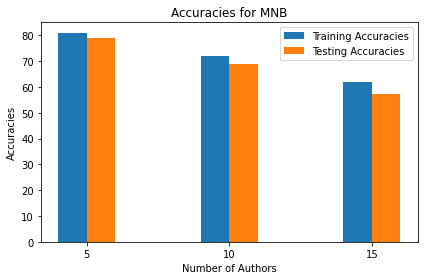

In [11]:
training_acc = [0.8102720129469196*100, 0.7212515372853989*100, 0.6178672150172517*100]
testing_acc = [0.7892883412141186*100, 0.6877449931915112*100, 0.573715359007382*100]
labels = ["5", "10", "15"]
x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_acc, width, label='Training Accuracies')
rects2 = ax.bar(x + width/2, testing_acc, width, label='Testing Accuracies')
ax.set_ylabel('Accuracies')
ax.set_title('Accuracies for MNB')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Number of Authors")
ax.legend()
fig.tight_layout()

plt.show()

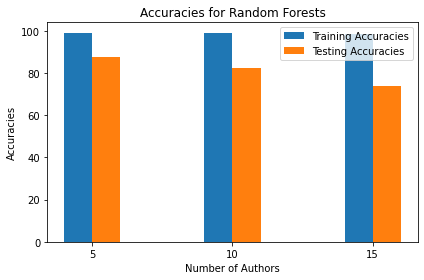

In [12]:
training_acc = [0.9906395218946249*100, 0.9906761780109768*100, 0.9851002386861634*100]
testing_acc = [0.8742850606958721*100, 0.8225523643440728*100, 0.7377848181008305*100]
labels = ["5", "10", "15"]
x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, training_acc, width, label='Training Accuracies')
rects2 = ax.bar(x + width/2, testing_acc, width, label='Testing Accuracies')
ax.set_ylabel('Accuracies')
ax.set_title('Accuracies for Random Forests')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_xlabel("Number of Authors")
ax.legend()
fig.tight_layout()

plt.show()

Here we have plotted the graphs for the training and testing accuracies for MNB and Random Forests across 5, 10 and 15 authors. RandomForest Classifer gives us the best accuracy

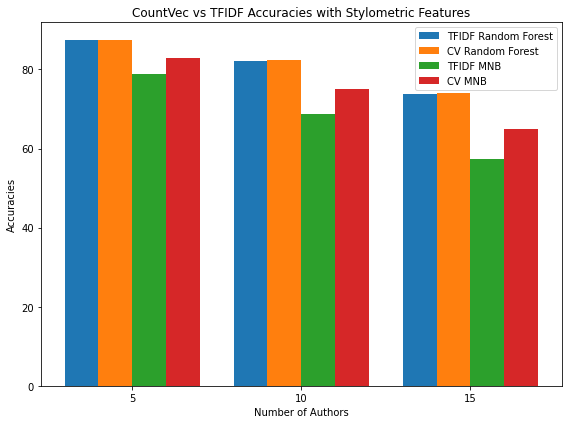

In [5]:
tf_rf_testing_acc = [0.8742850606958721*100, 0.8225523643440728*100, 0.7377848181008305*100]
tf_mnb_testing_acc =[0.7892883412141186*100, 0.6877449931915112*100, 0.573715359007382*100]
cv_rf_testing_acc = [0.8752198449986552*100, 0.8235547537382457*100, 0.7405637585852928*100]
cv_mnb_testing_acc = [0.8279937557031998*100, 0.7501791885052154*100, 0.6502273816970358*100]

labels = [5,10,15]
# ["Random Forests", "MultinomialNB"]
x = np.arange(len(labels))
length = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x + width, tf_rf_testing_acc, width, label='TFIDF Random Forest')
rects2 = ax.bar(x + 2*width, cv_rf_testing_acc, width, label='CV Random Forest')
rects3 = ax.bar(x + 3*width, tf_mnb_testing_acc, width, label='TFIDF MNB')
rects4 = ax.bar(x + 4*width, cv_mnb_testing_acc, width, label='CV MNB')
ax.set_ylabel('Accuracies')
ax.set_title('CountVec vs TFIDF Accuracies with Stylometric Features')
ax.set_xticks(x+(2.5*width))
ax.set_xticklabels(labels)
ax.set_xlabel("Number of Authors")

ax.legend()
fig.tight_layout()
plt.rcParams["figure.figsize"] = (8,6)
plt.show()
